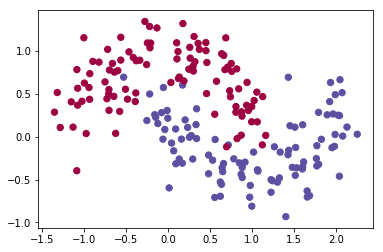

In [125]:
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegressionCV

import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

np.random.seed(0)

X, y = make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

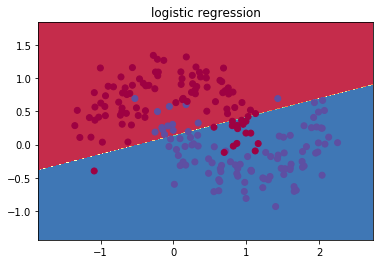

In [126]:
# train a basic logistic classifier
clf = LogisticRegressionCV()
clf.fit(X, y)

# %% 4 
# Helper function to plot a decision boundary. 
# If you don't fully understand this function don't worry, it just generates the contour plot below. 
def plot_decision_boundary(pred_func): 
    # Set min and max values and give it some padding 
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 
    h = 0.01 
    # Generate a grid of points with distance h between them 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
    # Predict the function value for the whole gid 
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape) 
    # Plot the contour and training examples 
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral) 
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral) 
    
#plot decision boundary
plot_decision_boundary(lambda x:clf.predict(x))
plt.title("logistic regression")

In [127]:
# ok - now let's try a neural net

# training set size
num_examples = len(X)
#input layer dimensions
nn_input_dim = 2
#output layer dimensions
nn_output_dim = 2

# gradient descent parameters
#  learning rate
epsilon0 = 0.01 
#  regularization strength
reg_lambda = 0.01




$$L(y,\hat y) = \frac{-1}{N} \sum_{n \in N}\sum_{i \in C}y_{n,i} \log \hat y_{n,i}$$

In [128]:
# define loss function

# L(y, yhat) = -1/n*Sum(n->N)Sum(i->C)yn

def forward_prop(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    #forward propagation to calculate predictions
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores/np.sum(exp_scores, axis=1, keepdims=True)
    return {'probs': probs, 'z1': z1, 'a1': a1, 'z2': z2, 'exp_scores': exp_scores}

def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    probs = forward_prop(model, X)['probs']
    # calculate loss
    correct_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(correct_logprobs)
    # Add Regularization term to loss(optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1))+np.sum(np.square(W2)))
    return 1./num_examples*data_loss

# helper function to calculate output
    

In [160]:
def update_learning_rate(method, epsilon0, t, k = 0, step_decay=10, epsilon=0):
    if method is "step":
        if(step%step_decay==0):
            return epsilon/2
    elif method is "exponential":
        return epsilon0*math.exp(-k*t)
    elif method is "t-decay":
        return epsilon0/(1+(k*t))
    else:
        return epsilon0

In [171]:


def predict(model, x):
    probs = forward_prop(model, x)['probs']
    return np.argmax(probs, axis=1)


def build_model(nn_hdim, num_passes=20000, print_loss=False):
    # initialize the params randomly
    np.random.seed(40)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1,nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim)/np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    
    # output variable
    model = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    epsilon = epsilon0
    # gradient descent, for each batch
    for i in range(0, num_passes):
        #forward prop
        prop_values = forward_prop(model, X)
        probs = prop_values['probs']
        a1 = prop_values['a1']
              
        # backprop
        delta3 = probs
        delta3[range(num_examples),y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T)*(1-np.power(a1,2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        # add regularization (b1, b2 dont have regularization terms)
        dW2 += reg_lambda * model['W2']
        dW1 += reg_lambda * model['W1']
        
        # gradient descent param update
        # assign updated params to model
        model['W1'] += -epsilon * dW1
        model['b1'] += -epsilon * db1
        model['W2'] += -epsilon * dW2
        model['b2'] += -epsilon * db2
        epsilon = update_learning_rate(method="exponential", epsilon0=epsilon0, t=i, k=0.0005)
        
        # print loss if option on
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
        
    return model

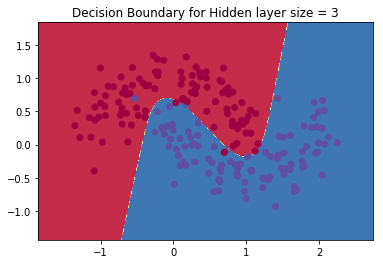

In [172]:
# build a model with a 3 dim hidden layer

model = build_model(3, print_loss=False)
# plot decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for Hidden layer size = 3")

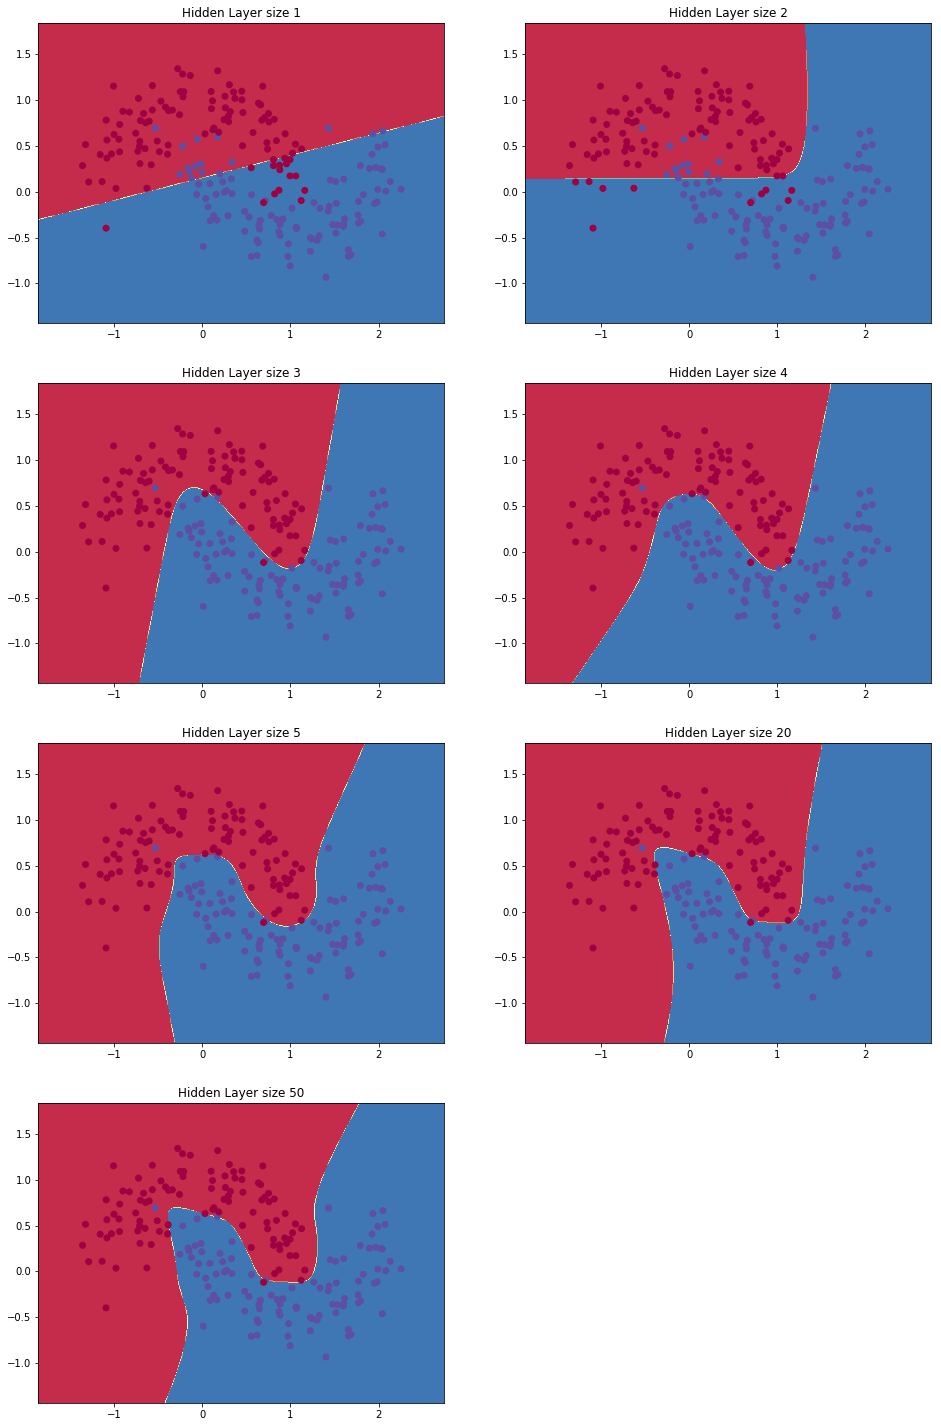

In [173]:
# playing with dimensions of hidden layer
plt.figure(figsize=(16,32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title("Hidden Layer size %d" % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x:predict(model, x))
plt.show()